# Decision Trees and Nearest Neighbors
A writeup of the second half of Chapter 3 of Sebastian Raschka's Machine Learning with Python Book. Most figures are from his book and some problems are derived from examples discussed in *Introduction to Machine Learning with Python* by Müller and Guido.
<break> -Alex Pizzuto

In [9]:
from IPython.display import Image
import numpy as np
%matplotlib inline

As suggested by the name, the method is breaking down our data by making decisions based on asking a series of questions (making it one of the more interpretable models for beyond 2 features). Even though this decision tree would have us all in the left subtree immediately, for example's sake:
![title](images/03_17.png)

The goal is to split the data in such a way that you have the most discriminating power at each level, we call this procedure maximizing the **information gain**. It is defined at each level as:
$$I G \left( D _ { p } , f \right) = I \left( D _ { p } \right) - \sum _ { j = 1 } ^ { m } \frac { N _ { j } } { N _ { p } } I \left( D _ { j } \right)$$.
Simply put, it's the difference between the impurity of the parent node and the sum of the child node impurities, so the lower the impurity in child nodes, the larger the information gain.

(btw, for all people that want quick ways to typeset equations from textbooks that you have pdfs of: [MathPix](https://mathpix.com/) ). 

For simplification, most decision tree classifiers are binary. We will work under that assumption from this point forwards, and all equations and such are only *guaranteed* to be applicable to binary decision trees. We then define three quantities, the **Gini Index** $I_G$, **entropy** $I_H$, and **classification error**, $I_E$. Mathematically, they are defined as:
$$I _ { H } ( t ) = - \sum _ { i = 1 } ^ { c } p ( i | t ) \log _ { 2 } p ( i | t )$$
$$I _ { G } ( t ) = \sum _ { i = 1 } ^ { \epsilon } p ( i | t ) ( - p ( i | t ) ) = 1 - \sum _ { i = 1 } ^ { c } p ( i | t ) ^ { 2 }$$
$$I _ { E } = 1 - \max \{ p ( i | t ) \}$$
In this context, entropy is a measure of mixing of classes for a given node, and the Gini index is a criterion to minimize the probability of misclassification. Lets find the information gain of the parent node as well as the gini index, entropy, and classification error with this toy example: ![title](images/03_18.png)

| Variable|  A | B | 
|------|------|------|
|   Information Gain  | 0.25| 0.25|
|Gini Index | 0.125 | 0.16 |
|Entropy | 0.19 | 0.31 |

One quantity Raschka's book hasn't mentioned yet is **feature importance**. It's a quantity between 0 and 1 and it rates how important each feature is for the decision tree it makes (0 meaning not used at all and 1 meaning that the feature perfectly predicts the target).

###  Example: Plotting impurity indices for class 1

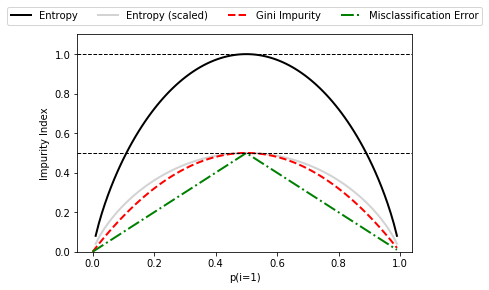

In [6]:
import matplotlib.pyplot as plt
import numpy as np


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
#plt.savefig('images/03_19.png', dpi=300, bbox_inches='tight')
plt.show()

### Some initialization stuff from earlier in the chapter

In [22]:
from matplotlib.colors import ListedColormap
from sklearn import datasets


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')
        
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

## Now we build a decision tree

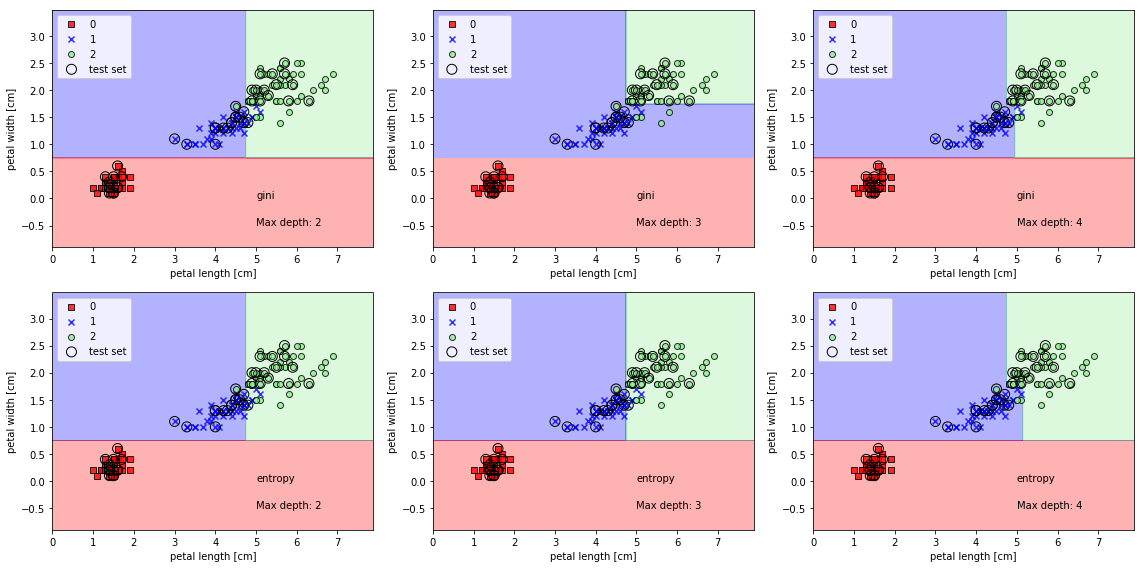

In [18]:
from sklearn.tree import DecisionTreeClassifier

plt.figure(figsize=(16,8))

counter = 1
for criterion in ['gini', 'entropy']:
    for depth in [2, 3, 4]:
        tree = DecisionTreeClassifier(criterion=criterion, 
                              max_depth=depth, 
                              random_state=1)
        tree.fit(X_train, y_train)

        X_combined = np.vstack((X_train, X_test))
        y_combined = np.hstack((y_train, y_test))
        plt.subplot(2,3,counter)
        plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150))
        counter += 1
        plt.xlabel('petal length [cm]')
        plt.ylabel('petal width [cm]')
        plt.legend(loc='upper left')
        plt.text(5, 0., criterion)
        plt.text(5, -0.5, "Max depth: {}".format(depth))
        

plt.tight_layout()
#plt.savefig('images/03_20.png', dpi=300)
plt.show()

Note: Any given decision tree from scikit-learn can be exported as a `.dot` and visualized with GraphViz, giving you something like this: ![title](images/03_21.png)

## Random Forests

Random forests are ensembles of decision trees. Ensembles combine **weak learners** (to build a more robust model) with **strong learners** (better generalization error, less susceptible to overfitting). Random forests algorithm is as follows: 
1. Draw a random **bootstrap** sample of size *n* (randomly choose *n* samples from the training set with replacement).
2. Grow a decision tree from the bootstrap sample. At each node:
    1. Randomly select *d* features without replacement.
    2. Split the node using the feature that provides the best split according to the objective function, for instance, by maximizing the information gain.
3. Repeat the steps 1 to 2 *k* times.
4. Aggregate the prediction by each tree to assign the class label by **majority vote**.

Overall: Random forests are less interpretable than simpler decision trees, but don't require as much hyperparameter tuning or pruning. Usually the size of the bootstrap sample is of the order of the number of samples in the original training set for good bias-variance tradeoff. And usually we pick $d \approx \sqrt{\text{number of features}}$

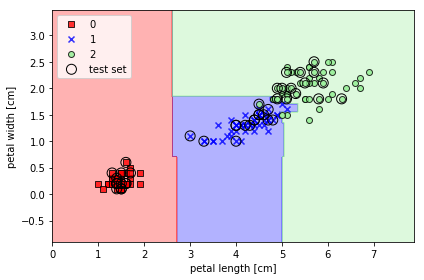

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
    #This means there are 10 decision trees, and are splitting using gini as our impurity measure
    #n_jobs is to parallelize the model training

forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_22.png', dpi=300)
plt.show()

## K-nearest neighbors

**lazy learner** because there is no discriminative function from the training data, it just memorizes the training data. Algorithm is simple:
1. Choose the number of k and a distance metric.
2. Find the k nearest neighbors of the sample that we want to classify.
3. Assign the class label by majority vote.
![title](images/03_23.png)

But the complexity grows linearly with sample size. There is also a regression variant of the k-nearest neighbors algorithm (which I won't go into here, but the other book has a good write up on it)

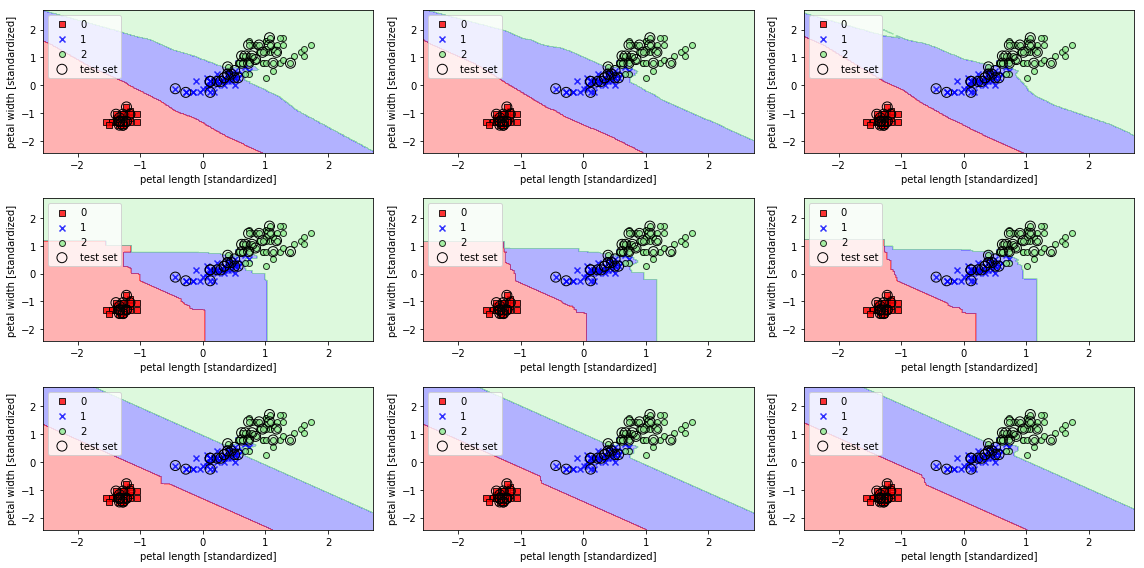

In [35]:
from sklearn.neighbors import KNeighborsClassifier

plt.figure(figsize=(16,8))

counter = 1
for metric in ['euclidean', 'manhattan', 'chebyshev']:
    for neighbors in range(3, 9, 2):
        knn = KNeighborsClassifier(n_neighbors=neighbors, 
                                   metric=metric)
        knn.fit(X_train_std, y_train)
        plt.subplot(3, 3, counter)
        plot_decision_regions(X_combined_std, y_combined, 
                              classifier=knn, test_idx=range(105, 150))

        plt.xlabel('petal length [standardized]')
        plt.ylabel('petal width [standardized]')
        plt.legend(loc='upper left')
        plt.tight_layout()
        counter += 1
        
#plt.savefig('images/03_24.png', dpi=300)
plt.show()

# Practice Problems
## K-Nearest Neighbors

First, about our dataset: Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image, and the classes are either 'malignant' or 'benign'. And it's a dataset that originates from UW-Madison!

### Statement of Problem
Using a k-nearest neighbors algorithm with 50% training data and 50% testing data, optimize your parameters (*k*, metric, features) to maximize the testing accuracy. Highest testing accuracy gets a free coffee from Aldo's or Badger Mart, courtesy of yours truly. Each model is only allowed to be trained on 3 features.

In [41]:
#features in the dataset:
cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [40]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                    stratify = cancer.target, random_state = 1, test_size=0.5)
#for the problem, slice cancer.data to only grab 3 features from it

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

### The beginning of a solution (trying n_neighbors from 1 to 10 but with all features)

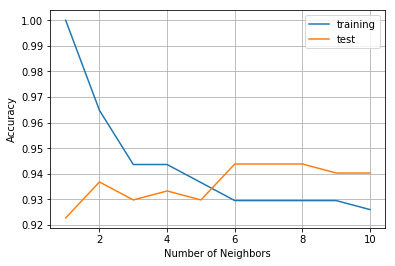

In [45]:
training_accuracy = []
test_accuracy = []

for n_neighbors in range(1,11):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    training_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(range(1,11), training_accuracy, label = "training")
plt.plot(range(1,11), test_accuracy, label = "test")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

## Decision Trees Problem

Using the same dataset as before, create a random forest classifier with the maximum accuracy on the test set, and plot the feature importance for all features. Are there any similarities between the feature importance with the random forest and the features you found maximized accuracy in the nearest neighbors problem?

In [51]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                    stratify = cancer.target, random_state = 1, test_size=0.5)
forest = RandomForestClassifier(n_estimators = 15, random_state = 1)
forest.fit(X_train, y_train)
print("Accuracy on training set: {0:.2f}%".format(forest.score(X_train, y_train)*100.))
print("Accuracy on testing set: {0:.2f}%".format(forest.score(X_test, y_test)*100.))

Accuracy on training set: 99.65%
Accuracy on testing set: 95.09%
